In [1]:
import src.test_functions as test_functions

In [2]:
import os

os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.1'
os.environ['XLA_FLAGS']='--xla_gpu_force_compilation_parallelism=1'

In [3]:
import scipy
import numpy as np
from jax import numpy as jnp

In [4]:
import matplotlib.pyplot as plt

In [5]:
import torch.nn as nn
import torch

from tqdm import tqdm

In [6]:
from sympy import symbols, Max
import sympy

In [7]:
from pyibex import Interval, IntervalVector, Function, CtcFwdBwd, SepFwdBwd, GEQ

In [8]:
seed = 12

import random
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

##  Sample points for training

In [9]:
def sample(function, bounds, n, local_minima=False):
    assert isinstance(bounds, np.ndarray)
    assert bounds.shape[1] == 2
    xs = np.random.rand(n, bounds.shape[0]) * (bounds[:, 1] - bounds[:, 0]) + bounds[:, 0]
    ys = np.array([function(x).item() for x in xs])
    
    if local_minima:
        xs_local_opt = []
        ys_local_opt = []
        for x0 in xs:
            opt_res = scipy.optimize.minimize(func, x0, method='Nelder-Mead')
            if opt_res.success:
                xs_local_opt.append(opt_res.x)
                ys_local_opt.append(opt_res.fun)
        xs_local_opt, ys_local_opt = np.array(xs_local_opt), np.array(ys_local_opt)
        return xs, ys, xs_local_opt, ys_local_opt
    
    return xs, ys

In [10]:
dimension = 1

func = test_functions.Ackley(dims=dimension)
# variables, expression = func.expression()

bounds = func.get_default_domain()
lb = bounds.T[0]
ub = bounds.T[1]

In [11]:
xs = np.arange(lb[0], ub[0], 0.01)
ys = np.array([func(jnp.array([x])).item() for x in xs])

In [12]:
# sampled_xs, sampled_ys = sample(func, bounds, 100)
sampled_xs, sampled_ys, sampled_xs_local_min, sampled_ys_local_min = sample(func, bounds, 100, local_minima=True)

/home/zhizhen/anaconda3/envs/mcmm/lib/python3.9/site-packages/numpy/core/getlimits.py:511: UserWarning: Signature b'\xcc\xcc\xcc\xbd' for <class 'numpy.float32'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/home/zhizhen/anaconda3/envs/mcmm/lib/python3.9/site-packages/numpy/core/_machar.py:295: RuntimeWarning: overflow encountered in divide
  xmax = xmax / (xmin*beta*beta*beta)


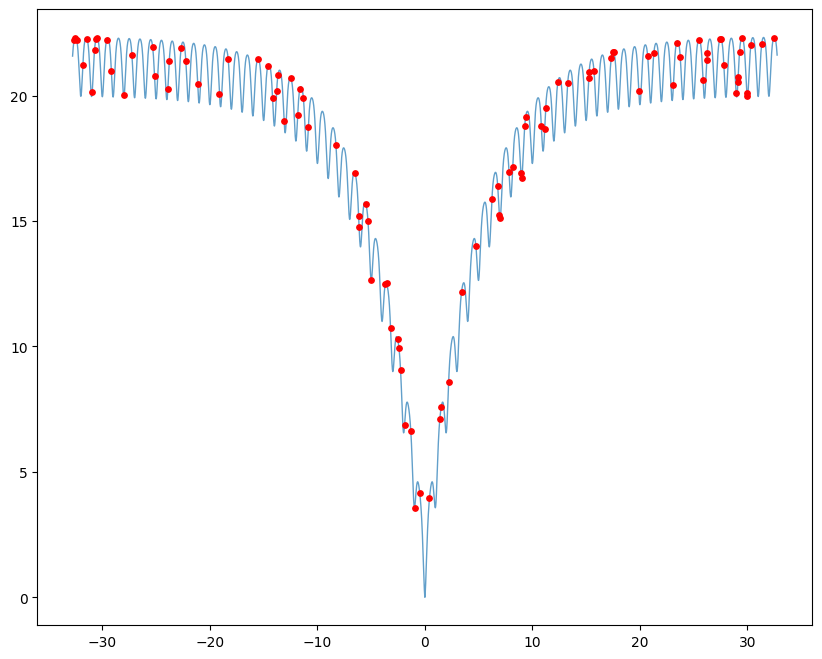

In [13]:
fig = plt.figure(figsize=(10,8))
plt.scatter(sampled_xs[:, 0], sampled_ys, s=15, c='red', zorder=10)
# plt.scatter(sampled_xs_local_min[:, 0], sampled_ys_local_min, s=15, c='red', zorder=10)

plt.plot(xs, ys, zorder=1, linewidth=1, alpha=0.7)


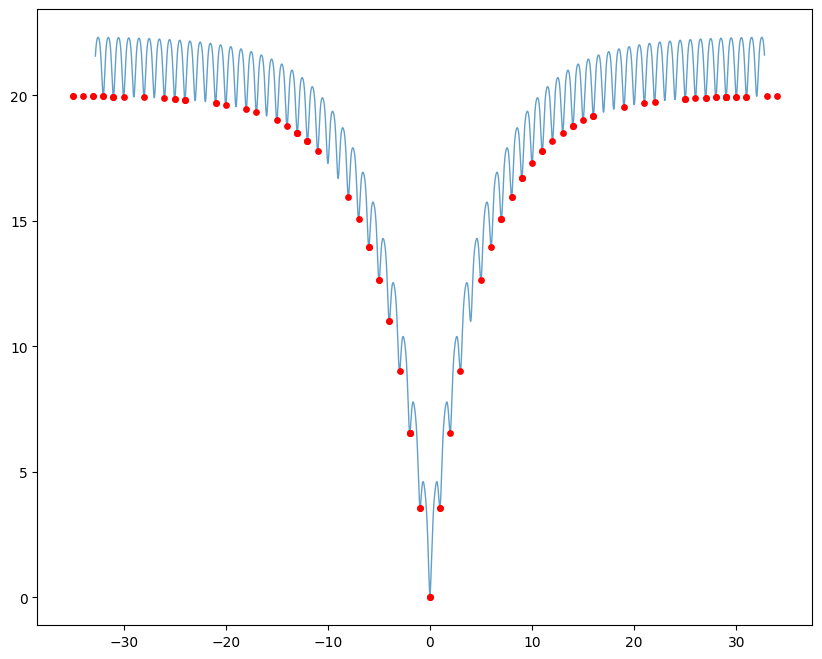

In [14]:
fig = plt.figure(figsize=(10,8))
# plt.scatter(sampled_xs[:, 0], sampled_ys, s=15, c='red', zorder=10)
plt.scatter(sampled_xs_local_min[:, 0], sampled_ys_local_min, s=15, c='red', zorder=10)

plt.plot(xs, ys, zorder=1, linewidth=1, alpha=0.7)


## Fit a neural network

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
xs_train = sampled_xs
ys_train = np.expand_dims(sampled_ys, axis=1)

In [17]:
hidden_dim = 16

model = nn.Sequential(
    nn.Linear(dimension, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, 1)
)

In [18]:
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [19]:
num_epochs = 10000

model.to(device)

loss_record = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    
    x_train_tensor = torch.FloatTensor(xs_train).to(device)
    y_train_tensor = torch.FloatTensor(ys_train).to(device)
    y_pred = model(x_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    
    loss_record.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2258.60it/s]


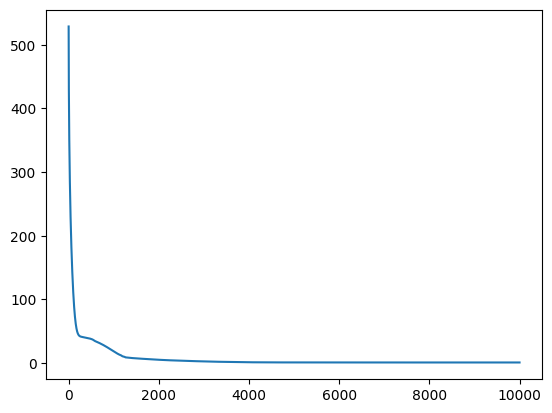

In [20]:
plt.plot(loss_record)

In [21]:
loss_record[-1]

0.759334921836853

In [22]:
with torch.no_grad():
    fitted_ys = model(torch.FloatTensor(np.expand_dims(xs, axis=1)).to(device)).detach().cpu().squeeze().numpy()

In [23]:
abs(ys - fitted_ys)

array([0.24186897, 0.17304039, 0.10809898, ..., 0.00898361, 0.07125282,
       0.13744164])

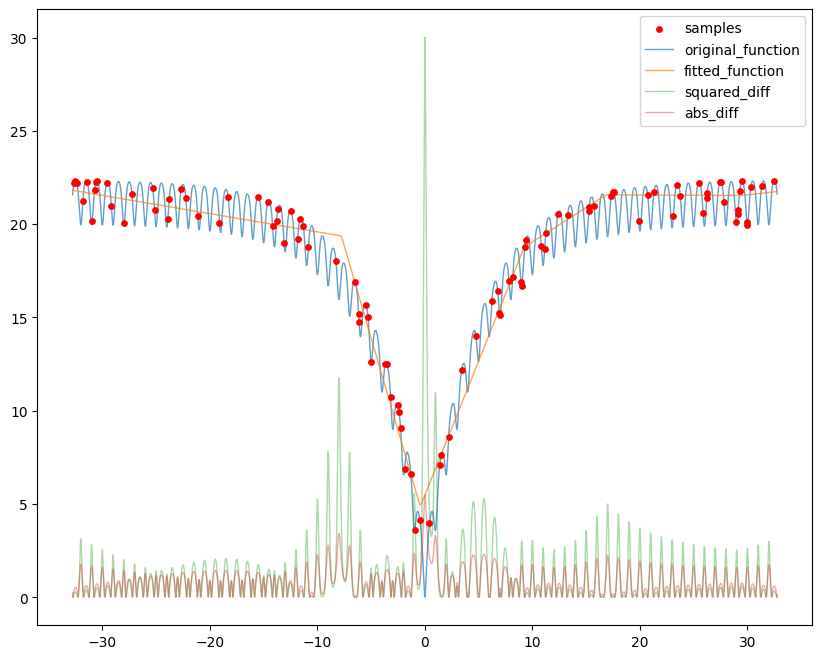

In [24]:
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(xs_train[:, 0], ys_train[:, 0], s=15, c='red', zorder=10, label="samples")
# plt.scatter(sampled_xs_local_min[:, 0], sampled_ys_local_min, s=15, c='red', zorder=10)

ax.plot(xs, ys, zorder=1, linewidth=1, alpha=0.7, label="original_function")
ax.plot(xs, fitted_ys, linewidth=1, alpha=0.7, label="fitted_function")

y_diff_squared = (ys - fitted_ys) ** 2
ax.plot(xs, y_diff_squared, linewidth=1, alpha=0.4, label="squared_diff")

y_diff_abs = abs(ys - fitted_ys)
ax.plot(xs, y_diff_abs, linewidth=1, alpha=0.4, label="abs_diff")

ax.legend()

## Convert the neural network to ibex expression (through sympy) 

In [25]:
layer_idx = 2
layer = model[layer_idx]

In [26]:
weight = layer.weight
bias = layer.bias
width = weight.shape[1]

In [27]:
inter_vars = symbols(', '.join(['x[{}][{}]'.format(layer_idx, i) for i in range(width)]))

In [28]:
inter_vars

(x[2][0],
 x[2][1],
 x[2][2],
 x[2][3],
 x[2][4],
 x[2][5],
 x[2][6],
 x[2][7],
 x[2][8],
 x[2][9],
 x[2][10],
 x[2][11],
 x[2][12],
 x[2][13],
 x[2][14],
 x[2][15])

In [29]:
X = np.expand_dims(np.array(inter_vars), axis=1)

In [30]:
W = weight.detach().cpu().numpy()

In [31]:
b = bias.detach().cpu().numpy()
b

array([0.52257335], dtype=float32)

In [32]:
expression = (W @ X).squeeze(axis=1) + b
expression = expression.item()

In [33]:
layer_idx = 1
layer = model[layer_idx]
layer

ReLU()

In [34]:
prev_inter_vars = inter_vars
width = len(inter_vars)
inter_vars = symbols(', '.join(['x[{}][{}]'.format(layer_idx, i) for i in range(width)]))

In [35]:
inter_vars[0]

x[1][0]

In [36]:
replace_dict = {}
for curr_var, prev_var in zip(inter_vars, prev_inter_vars):
    replace_dict[prev_var] = Max(curr_var, 0)

In [37]:
prev_expression = expression
for key in replace_dict:
    expression = expression.subs(key, replace_dict[key])

In [38]:
expression

0.884868741035461*Max(0, x[1][0]) + 0.475360929965973*Max(0, x[1][10]) - 0.000597771839238703*Max(0, x[1][11]) + 0.617979466915131*Max(0, x[1][12]) + 0.52612030506134*Max(0, x[1][13]) + 0.764136075973511*Max(0, x[1][14]) + 0.560698747634888*Max(0, x[1][15]) + 0.401442497968674*Max(0, x[1][1]) - 0.0746359974145889*Max(0, x[1][2]) - 2.21276712417603*Max(0, x[1][3]) + 0.678389072418213*Max(0, x[1][4]) - 3.13345265388489*Max(0, x[1][5]) - 1.93147969245911*Max(0, x[1][6]) + 0.911122024059296*Max(0, x[1][7]) + 0.653740644454956*Max(0, x[1][8]) - 1.44713449478149*Max(0, x[1][9]) + 0.522573351860046

In [39]:
layer_idx = 0
layer = model[layer_idx]
layer

Linear(in_features=1, out_features=16, bias=True)

In [40]:
weight = layer.weight
bias = layer.bias
width = weight.shape[1]

In [41]:
prev_inter_vars = inter_vars
inter_vars = symbols(', '.join(['x[{}]'.format(i) for i in range(width)]))
if isinstance(inter_vars, sympy.Symbol):
    inter_vars = [inter_vars]

In [42]:
X = np.expand_dims(np.array(inter_vars), axis=1)

In [43]:
W = weight.detach().cpu().numpy()

In [44]:
b = bias.detach().cpu().numpy()
b

array([ 1.7478607 ,  1.9974462 , -0.8134922 , -2.8359535 ,  1.8265467 ,
       -4.6611934 , -3.187311  , -0.3686461 ,  0.4596056 , -2.5597646 ,
       -0.39051932,  0.66646564,  1.0875053 ,  0.3596105 ,  0.27814165,
       -0.45984444], dtype=float32)

In [45]:
mat_res = (W @ X).squeeze(axis=1) + b

In [46]:
replace_dict = {}
for curr_expr, prev_var in zip(mat_res, prev_inter_vars):
    replace_dict[prev_var] = curr_expr
replace_dict

{x[1][0]: 0.029988756403327*x[0] + 1.74786067008972,
 x[1][1]: 1.99744617938995 - 0.0679977834224701*x[0],
 x[1][2]: -0.0249137133359909*x[0] - 0.813492178916931,
 x[1][3]: 0.168525412678719*x[0] - 2.8359534740448,
 x[1][4]: 1.82654666900635 - 0.0617917813360691*x[0],
 x[1][5]: -0.600023806095123*x[0] - 4.66119337081909,
 x[1][6]: 0.345310062170029*x[0] - 3.18731093406677,
 x[1][7]: -1.10742282867432*x[0] - 0.368646085262299,
 x[1][8]: 0.965751528739929*x[0] + 0.459605604410172,
 x[1][9]: 0.27729144692421*x[0] - 2.55976462364197,
 x[1][10]: -0.820364713668823*x[0] - 0.390519320964813,
 x[1][11]: 0.666465640068054 - 0.00287704169750214*x[0],
 x[1][12]: 0.00891453493386507*x[0] + 1.08750534057617,
 x[1][13]: 0.755448997020721*x[0] + 0.359610497951508,
 x[1][14]: 0.584354102611542*x[0] + 0.278141647577286,
 x[1][15]: -0.966290533542633*x[0] - 0.459844440221786}

In [47]:
prev_expression = expression
for key in replace_dict:
    expression = expression.subs(key, replace_dict[key])

In [48]:
str(expression)

'-0.000597771839238703*Max(0, 0.666465640068054 - 0.00287704169750214*x[0]) + 0.678389072418213*Max(0, 1.82654666900635 - 0.0617917813360691*x[0]) + 0.401442497968674*Max(0, 1.99744617938995 - 0.0679977834224701*x[0]) + 0.911122024059296*Max(0, -1.10742282867432*x[0] - 0.368646085262299) + 0.560698747634888*Max(0, -0.966290533542633*x[0] - 0.459844440221786) + 0.475360929965973*Max(0, -0.820364713668823*x[0] - 0.390519320964813) - 3.13345265388489*Max(0, -0.600023806095123*x[0] - 4.66119337081909) - 0.0746359974145889*Max(0, -0.0249137133359909*x[0] - 0.813492178916931) + 0.617979466915131*Max(0, 0.00891453493386507*x[0] + 1.08750534057617) + 0.884868741035461*Max(0, 0.029988756403327*x[0] + 1.74786067008972) - 2.21276712417603*Max(0, 0.168525412678719*x[0] - 2.8359534740448) - 1.44713449478149*Max(0, 0.27729144692421*x[0] - 2.55976462364197) - 1.93147969245911*Max(0, 0.345310062170029*x[0] - 3.18731093406677) + 0.764136075973511*Max(0, 0.584354102611542*x[0] + 0.278141647577286) + 0.5

In [49]:
variables, func_expr = func.expression()

In [50]:
func_expr

' (-(20) * exp(-(0.2)*sqrt(( + (x[0]^2)) / 1))) + ( - exp(( + cos((6.283185307179586)*x[0])) / 1)) + ( + (20) + exp(1.0) )'

### (Finally..) prune the box

In [51]:
expr_nn = str(expression).replace("Max", "max")

In [52]:
expr_nn

'-0.000597771839238703*max(0, 0.666465640068054 - 0.00287704169750214*x[0]) + 0.678389072418213*max(0, 1.82654666900635 - 0.0617917813360691*x[0]) + 0.401442497968674*max(0, 1.99744617938995 - 0.0679977834224701*x[0]) + 0.911122024059296*max(0, -1.10742282867432*x[0] - 0.368646085262299) + 0.560698747634888*max(0, -0.966290533542633*x[0] - 0.459844440221786) + 0.475360929965973*max(0, -0.820364713668823*x[0] - 0.390519320964813) - 3.13345265388489*max(0, -0.600023806095123*x[0] - 4.66119337081909) - 0.0746359974145889*max(0, -0.0249137133359909*x[0] - 0.813492178916931) + 0.617979466915131*max(0, 0.00891453493386507*x[0] + 1.08750534057617) + 0.884868741035461*max(0, 0.029988756403327*x[0] + 1.74786067008972) - 2.21276712417603*max(0, 0.168525412678719*x[0] - 2.8359534740448) - 1.44713449478149*max(0, 0.27729144692421*x[0] - 2.55976462364197) - 1.93147969245911*max(0, 0.345310062170029*x[0] - 3.18731093406677) + 0.764136075973511*max(0, 0.584354102611542*x[0] + 0.278141647577286) + 0.5

In [53]:
variables

['x[1]']

In [54]:
def expression_squared_diff(expr1, expr2):
    return "(({}) - ({})) ^ 2".format(expr1, expr2)

In [55]:
def expression_absolute_diff(expr1, expr2):
    return "abs(({}) - ({}))".format(expr1, expr2)

In [56]:
def expression_add_const(expr, const):
    return "({}) + ({})".format(expr, const)

In [57]:
ibex_expression = expression_squared_diff(func_expr, expr_nn)

In [65]:
ibex_expression = expression_absolute_diff(func_expr, expr_nn)

In [66]:
ibex_expression = expression_add_const(ibex_expression, -00)

In [67]:
ibex_expression

'(abs(( (-(20) * exp(-(0.2)*sqrt(( + (x[0]^2)) / 1))) + ( - exp(( + cos((6.283185307179586)*x[0])) / 1)) + ( + (20) + exp(1.0) )) - (-0.000597771839238703*max(0, 0.666465640068054 - 0.00287704169750214*x[0]) + 0.678389072418213*max(0, 1.82654666900635 - 0.0617917813360691*x[0]) + 0.401442497968674*max(0, 1.99744617938995 - 0.0679977834224701*x[0]) + 0.911122024059296*max(0, -1.10742282867432*x[0] - 0.368646085262299) + 0.560698747634888*max(0, -0.966290533542633*x[0] - 0.459844440221786) + 0.475360929965973*max(0, -0.820364713668823*x[0] - 0.390519320964813) - 3.13345265388489*max(0, -0.600023806095123*x[0] - 4.66119337081909) - 0.0746359974145889*max(0, -0.0249137133359909*x[0] - 0.813492178916931) + 0.617979466915131*max(0, 0.00891453493386507*x[0] + 1.08750534057617) + 0.884868741035461*max(0, 0.029988756403327*x[0] + 1.74786067008972) - 2.21276712417603*max(0, 0.168525412678719*x[0] - 2.8359534740448) - 1.44713449478149*max(0, 0.27729144692421*x[0] - 2.55976462364197) - 1.931479692

In [68]:
f = Function(*variables, ibex_expression)
X_in = IntervalVector(Interval(-10, 10))

In [69]:
ctc = CtcFwdBwd(f, GEQ)  # root is when f = 0
ctc.contract(X_in)

In [72]:
X_in

([-10, 10])

## Convert the neural network to dReal

In [74]:
import dreal

In [82]:
initial_variables = [dreal.Variable('x[{}]'.format(i)) for i in range(dimension)]

In [123]:
curr_vars = initial_variables
formulas_by_layer = []
vars_by_layer = [initial_variables]

for layer_idx, layer in enumerate(model):
    prev_vars = curr_vars
    if isinstance(layer, nn.Linear):
        W = layer.weight.detach().cpu().numpy()
        b = np.expand_dims(layer.bias.detach().cpu().numpy(), axis=1)
        X = np.expand_dims(prev_vars, axis=1)
        
        curr_vars = [dreal.Variable("x[{}][{}]".format(layer_idx + 1, i)) for i in range(W.shape[0])]
        vars_by_layer.append(curr_vars)
        expressions = (W @ X + b)[:, 0]
        
        formulas = [(curr_var == expr) for curr_var, expr in zip(curr_vars, expressions)]
        formulas_by_layer.append(formulas)
        
    elif isinstance(layer, nn.ReLU):
        layer_width = len(prev_vars)
        curr_vars = [dreal.Variable("x[{}][{}]".format(layer_idx + 1, i)) for i in range(layer_width)]
        vars_by_layer.append(curr_vars)
        
        expressions = [dreal.Max(0, prev_var) for prev_var in prev_vars]
        
        formulas = [(curr_var == expr) for curr_var, expr in zip(curr_vars, expressions)]
        formulas_by_layer.append(formulas)
        

In [135]:
all_formulas = [formula for formulas in formulas_by_layer for formula in formulas]

In [136]:
all_formulas

[<Formula "(x[1][0] == (1.7478606700897217 + 0.029988756403326989 * x[0]))">,
 <Formula "(x[1][1] == (1.9974461793899537 - 0.067997783422470093 * x[0]))">,
 <Formula "(x[1][2] == (-0.81349217891693115 - 0.024913713335990906 * x[0]))">,
 <Formula "(x[1][3] == (-2.8359534740447998 + 0.16852541267871857 * x[0]))">,
 <Formula "(x[1][4] == (1.8265466690063477 - 0.061791781336069108 * x[0]))">,
 <Formula "(x[1][5] == (-4.6611933708190917 - 0.6000238060951233 * x[0]))">,
 <Formula "(x[1][6] == (-3.1873109340667724 + 0.34531006217002869 * x[0]))">,
 <Formula "(x[1][7] == (-0.36864608526229858 - 1.1074228286743165 * x[0]))">,
 <Formula "(x[1][8] == (0.45960560441017151 + 0.9657515287399292 * x[0]))">,
 <Formula "(x[1][9] == (-2.5597646236419677 + 0.2772914469242096 * x[0]))">,
 <Formula "(x[1][10] == (-0.39051932096481323 - 0.82036471366882325 * x[0]))">,
 <Formula "(x[1][11] == (0.6664656400680542 - 0.0028770416975021363 * x[0]))">,
 <Formula "(x[1][12] == (1.0875053405761719 + 0.0089145349338